# Importación de librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
import os
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import json
import ast
from urllib.request import urlopen
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from google.colab import drive
import nltk

In [2]:
%matplotlib inline

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

# Importación de la base

In [3]:
drive.mount('/content/drive')
train = pd.read_csv('/content/drive/MyDrive/ITBA/Análisis Predictivo/train.csv')
test = pd.read_csv('/content/drive/MyDrive/ITBA/Análisis Predictivo/test.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exploración de la base

¿Cuál es la dimensión de la base?

In [105]:
num_features = len(test.columns)
num_data_points = len(test)

print("Número de características:", num_features)
print("Número de filas:", num_data_points)

Número de características: 26
Número de filas: 4398


¿Qué columnas tiene?

In [5]:
train.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

¿Qué tipo de dato tiene cada columna?

In [6]:
for column in train.columns:
    data_type = train[column].dtype
    print(column, data_type)

id int64
belongs_to_collection object
budget int64
genres object
homepage object
imdb_id object
original_language object
original_title object
overview object
popularity float64
poster_path object
production_companies object
production_countries object
release_date object
runtime float64
spoken_languages object
status object
tagline object
title object
Keywords object
cast object
crew object
revenue int64


Resumen de los tipos de datos presentes en la base:

In [7]:
column_types = train.dtypes
unique_types = column_types.unique()

print("Tipos de datos presentes en la base:")
print(unique_types)

Tipos de datos presentes en la base:
[dtype('int64') dtype('O') dtype('float64')]


Gráfico para observar la frecuencia de cada tipo de dato

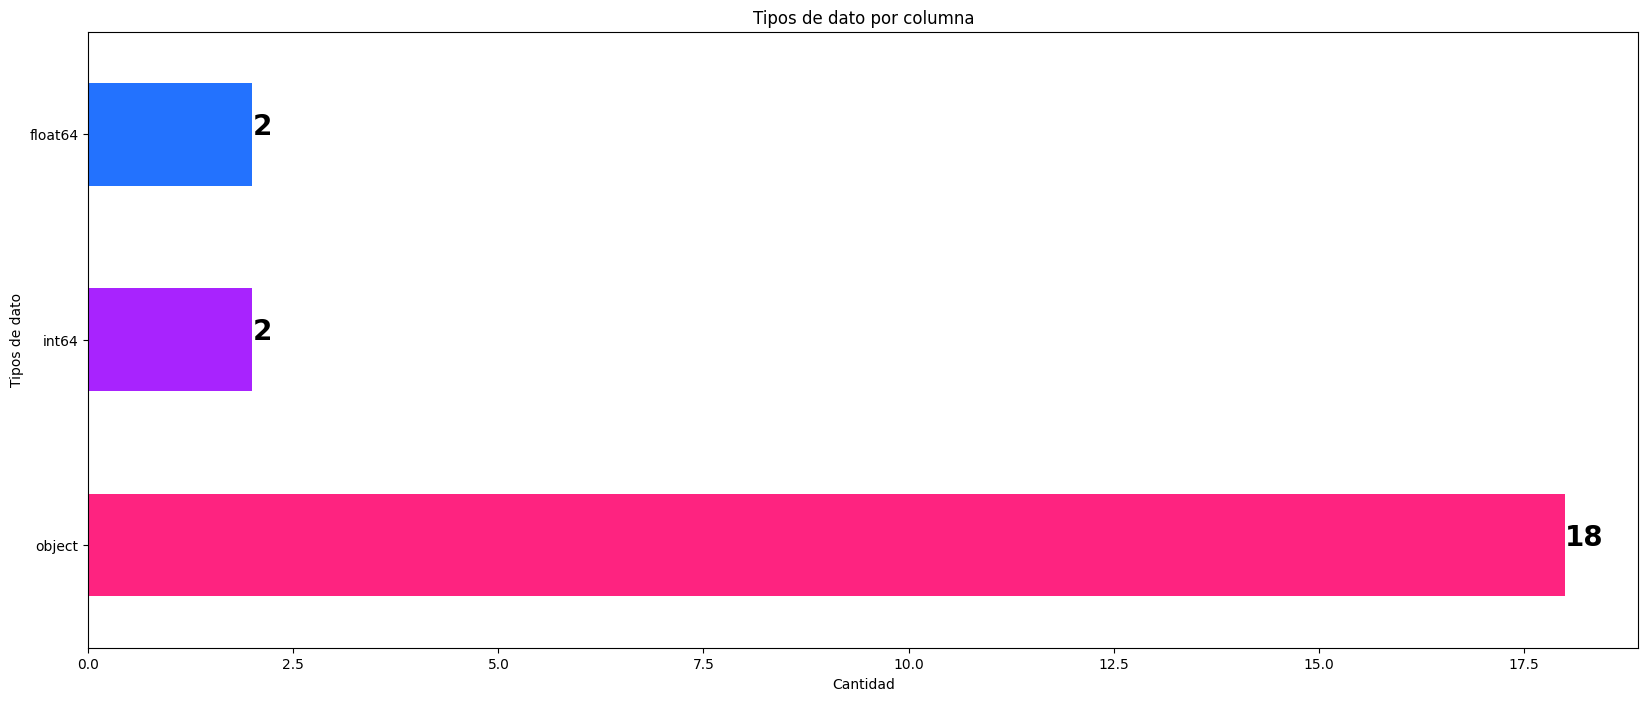

In [8]:
value_counts = test.dtypes.value_counts()

fig, ax = plt.subplots(figsize=(20, 8))

colors = ['#FE2380', '#A823FE', '#2372FE']

value_counts.plot(kind='barh', color=colors[:len(value_counts)])

for i, v in enumerate(value_counts):
    plt.text(v, i, str(v), fontweight='bold', fontsize=20)

plt.xlabel("Cantidad")
plt.ylabel("Tipos de dato")
plt.title("Tipos de dato por columna")
plt.show()

¿Cuántos valores nulos hay por columna?

In [9]:
train.isna().sum().sum()

5601

Gráfico para observar la presencia de valores nulos

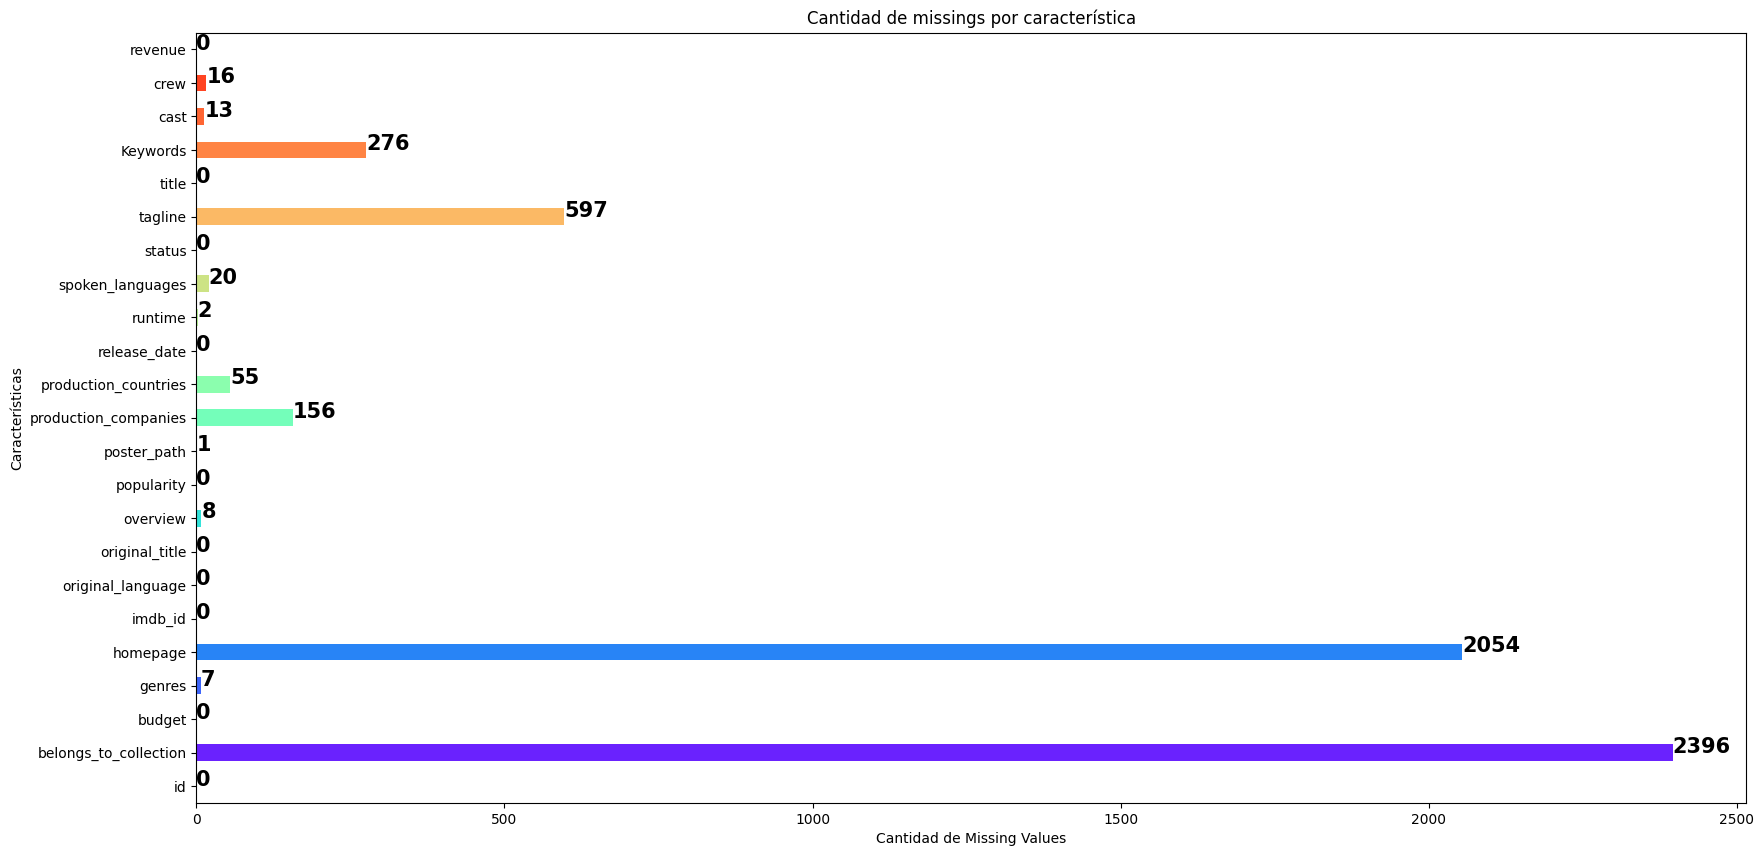

In [10]:
missing_counts = train.isna().sum()
colors = np.arange(len(missing_counts))

fig, ax = plt.subplots(figsize=(20, 10))
bar_colors = plt.cm.rainbow(colors / float(len(missing_counts)))
missing_counts.plot(kind='barh', color=bar_colors)

for i, v in enumerate(missing_counts):
    plt.text(v, i, str(v), fontweight='bold', fontsize=15)

plt.xlabel("Cantidad de Missing Values")
plt.ylabel("Características")
plt.title("Cantidad de missings por característica")
plt.show()

¿Cuáles son los rangos de valores de las variables numéricas?

In [11]:
def show_min_max_values(data):
    numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
    for column in numeric_columns:
        min_value = data[column].min()
        max_value = data[column].max()
        print(f"Columna: {column} | Valor mínimo: {min_value} | Valor máximo: {max_value}")

show_min_max_values(train)

Columna: id | Valor mínimo: 1 | Valor máximo: 3000
Columna: budget | Valor mínimo: 0 | Valor máximo: 380000000
Columna: popularity | Valor mínimo: 1e-06 | Valor máximo: 294.337037
Columna: runtime | Valor mínimo: 0.0 | Valor máximo: 338.0
Columna: revenue | Valor mínimo: 1 | Valor máximo: 1519557910


¿Hay outliers?

In [12]:
def detect_outliers(data, column):
    if data[column].dtype in ['int64', 'float64']:
        q1 = np.percentile(data[column], 25)
        q3 = np.percentile(data[column], 75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
        return len(outliers)

numeric_columns = train.select_dtypes(include=['int64', 'float64']).columns
for column in numeric_columns:
    num_outliers = detect_outliers(train, column)
    print(f"Columna: {column} | Número de outliers: {num_outliers}")


Columna: id | Número de outliers: 0
Columna: budget | Número de outliers: 249
Columna: popularity | Número de outliers: 70
Columna: runtime | Número de outliers: 0
Columna: revenue | Número de outliers: 315


No se considera ningún outlier como significativo

¿Cómo se correlacionan las variables numéricas?

<ipython-input-13-a8610a154e0b>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



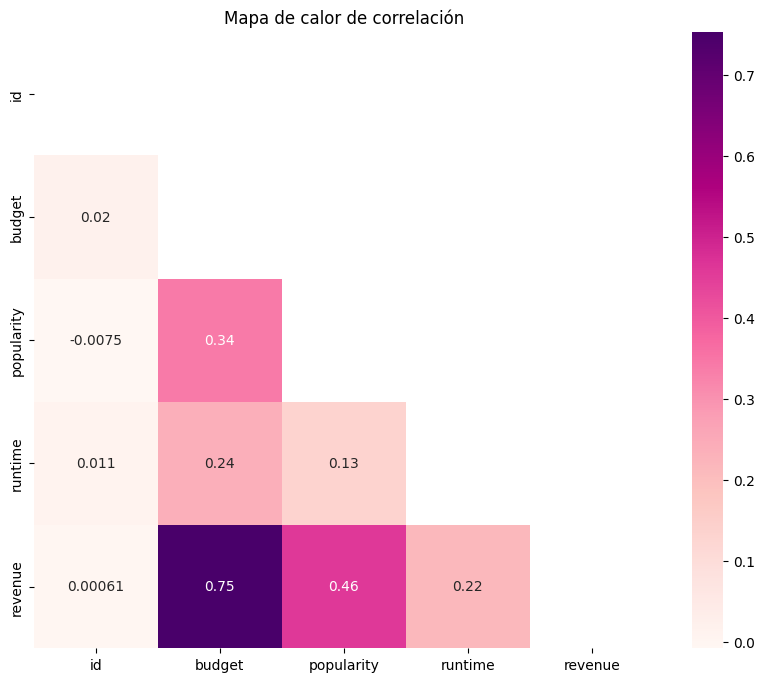

In [13]:
correlation_matrix = train.corr()

plt.figure(figsize=(10, 8))
cmap = sns.color_palette("RdPu", as_cmap=True)
sns.heatmap(correlation_matrix, annot=True, cmap=cmap, mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)))
plt.title('Mapa de calor de correlación')
plt.show()

Vamos a analizar más en detenimiento las variables 'Revenue' (target) y 'Budget'

<ipython-input-14-e181b10b95e7>:2: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



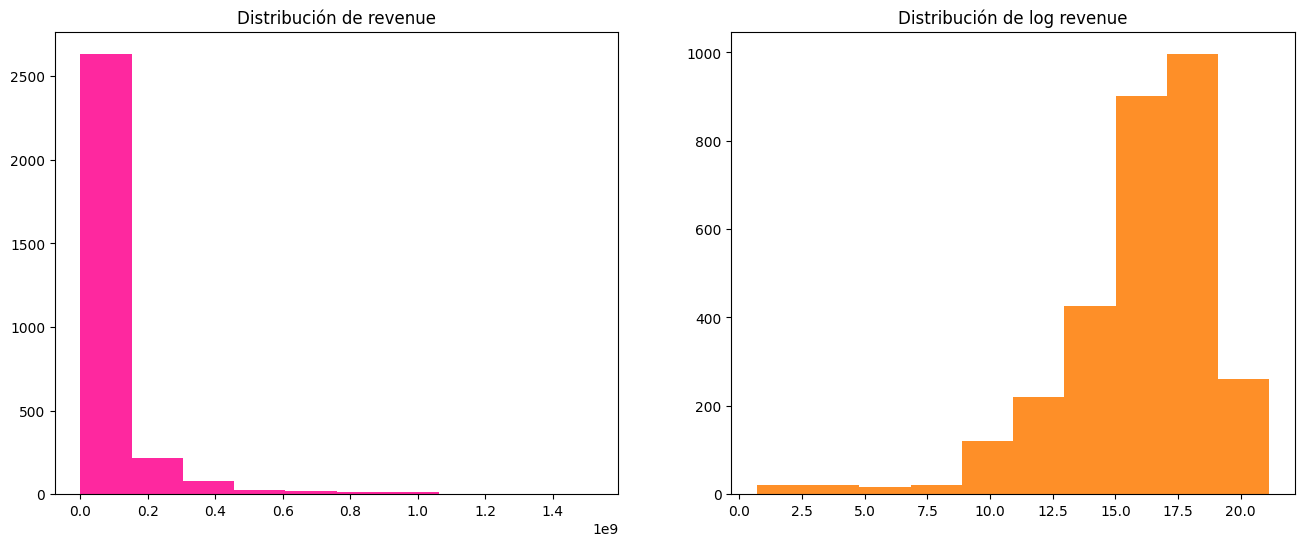

In [14]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train['revenue'], color = '#FE289F');
plt.title('Distribución de revenue');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['revenue']), color='#FE8F28');
plt.title('Distribución de log revenue');

<ipython-input-15-3bfc1fe07e4f>:2: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



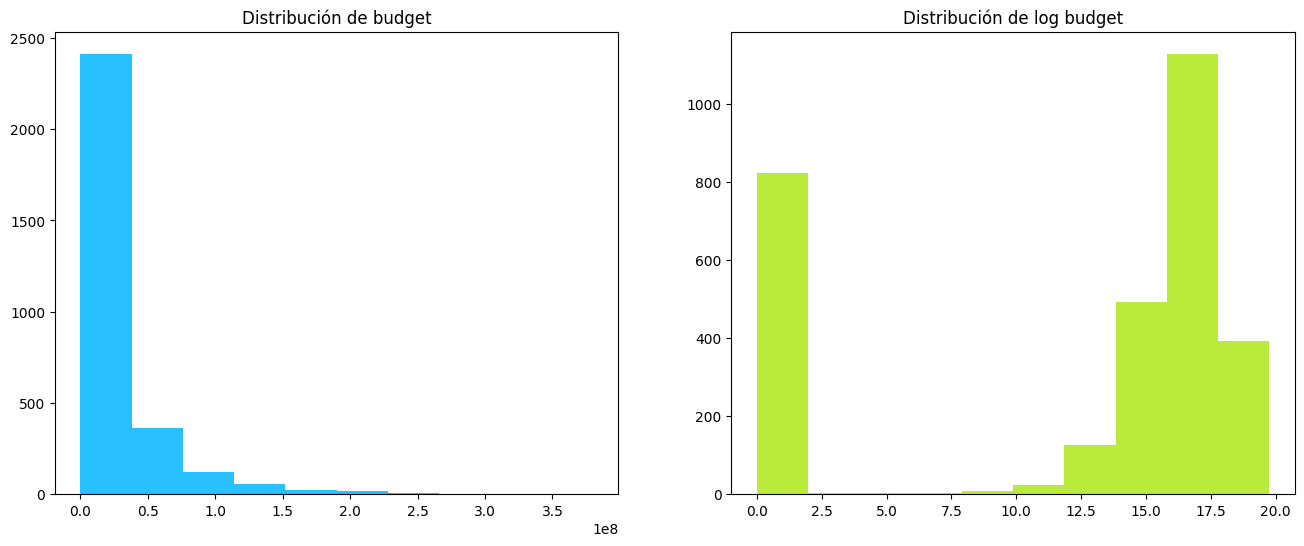

In [15]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train['budget'], color = '#28C0FE');
plt.title('Distribución de budget');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['budget']), color='#BAEB3A');
plt.title('Distribución de log budget');

Vamos a utilizar log revenue y log budget en vez de revenue y budget ya que estas últimas variables presentan una gran asimetría

Primera modificación de la base (solo en train ya que test no tiene el atributo Budget):

In [16]:
train['log_revenue'] = np.log1p(train['revenue'])

Segunda modificación de la base (en train y test)

In [17]:
train['log_budget'] = np.log1p(train['budget'])
test['log_budget'] = np.log1p(test['budget'])

¿Cómo se relacionan Revenue y Budget?

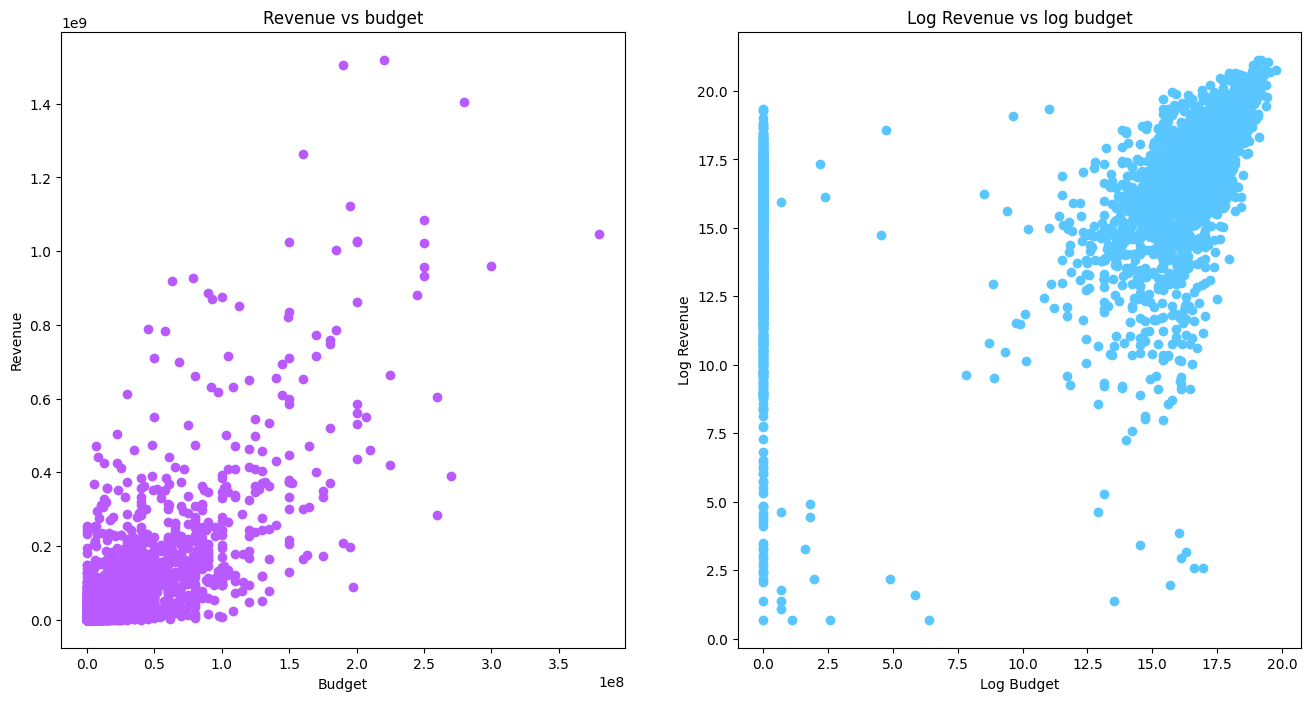

In [18]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.scatter(train['budget'], train['revenue'], color='#B95AFF')
plt.title('Revenue vs budget')
plt.xlabel('Budget')
plt.ylabel('Revenue')

plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['budget']), train['log_revenue'], color='#5AC6FF')
plt.title('Log Revenue vs log budget')
plt.xlabel('Log Budget')
plt.ylabel('Log Revenue')

plt.show()

¿Cómo se relaciona la variable 'Homepage' con Revenue?

In [19]:
train['homepage'].value_counts().head()

http://www.transformersmovie.com/               4
http://www.thehobbit.com/                       2
http://www.lordoftherings.net/                  2
http://sonyclassics.com/whiplash/               1
https://www.facebook.com/thefinesthoursmovie    1
Name: homepage, dtype: int64

3° modificación a las bases

In [20]:
train['has_homepage'] = 0
train.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1
test['has_homepage'] = 0
test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1

Gráfico oara observar como se relacionan has_homepage y Revenue

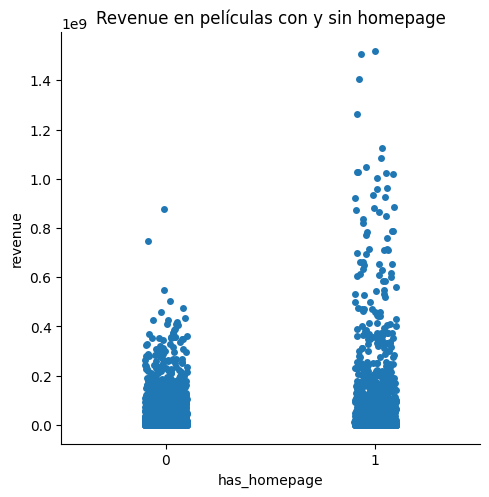

In [21]:
sns.catplot(x='has_homepage', y='revenue', data=train);
plt.title('Revenue en películas con y sin homepage');

¿Cómo se relaciona el idioma con el revenue?

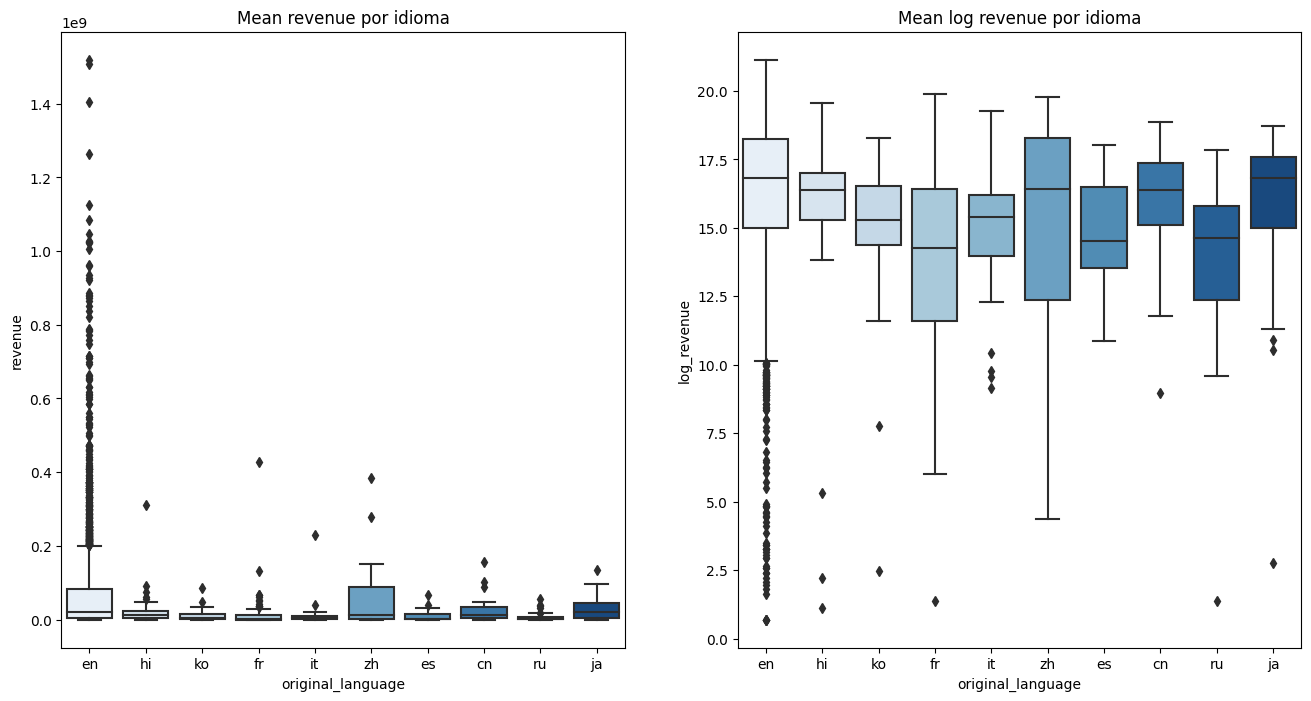

In [22]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.boxplot(x='original_language', y='revenue', data=train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)], palette='Blues')
plt.title('Mean revenue por idioma')

plt.subplot(1, 2, 2)
sns.boxplot(x='original_language', y='log_revenue', data=train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)], palette='Blues')
plt.title('Mean log revenue por idioma')

plt.show()

# Análisis de otras variables

¿Cuáles son las palabras mas populares en los títulos de las películas?

In [ ]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['original_title'].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top palabras en los títulos')
plt.axis("off")
plt.show()

¿Cuáles son las palabras más populares en la descripción de las películas?

In [ ]:
plt.figure(figsize=(12, 12))
text = ' '.join(train['overview'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000, colormap='cool').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Top palabras en Overview')
plt.axis("off")
plt.show()

# Limpieza de la base

A partir de acá se seguirá analizando la base como anteriormente pero además con la intención de limpiarla y transformar todos sus valores en numéricos

In [25]:
train_clean = train.copy()
test_clean = test.copy()

Se transforman las siguientes columnas en tipo diccionario para su utilización posterior

In [ ]:
dicc_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def texto_a_dicc(df):
    for column in dicc_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df

train_clean = texto_a_dicc(train)
test_clean = texto_a_dicc(test)

¿Cuántas películas pertenecen a una collection?

In [27]:
train_clean['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0).value_counts()

0    2396
1     604
Name: belongs_to_collection, dtype: int64

In [ ]:
counts = train_clean['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0).value_counts()

plt.figure(figsize=(8, 6))
plt.bar(counts.index, counts.values, color=['blue', 'red'])
plt.xlabel('Cantidad de películas')
plt.ylabel('Frecuencia')
plt.title('belongs_to_collection')
plt.xticks([0, 1])
plt.show()

Nueva variable para el nombre de las collections

In [29]:
train_clean['collection_name'] = train_clean['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
test_clean['collection_name'] = test_clean['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)

Nueva variable para indicar si la película pertenece a alguna collection o no

In [30]:
train_clean['has_collection'] = train_clean['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)
test_clean['has_collection'] = test_clean['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

Eliminacipon de 'belongs_to_collection'

In [31]:
train_clean = train_clean.drop(['belongs_to_collection'], axis=1)
test_clean = test_clean.drop(['belongs_to_collection'], axis=1)

¿Cuántos géneros tienen las películas?

In [ ]:
print('Número de géneros por película')
train_clean['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()

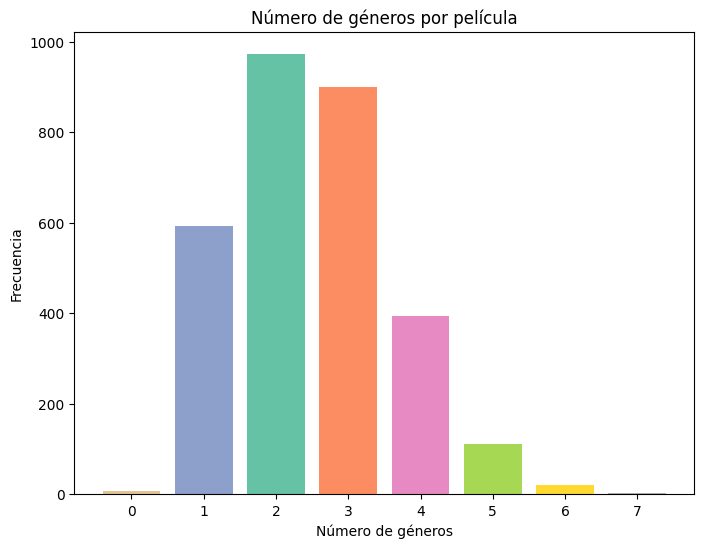

In [33]:
genre_counts = train_clean['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()

fig, ax = plt.subplots(figsize=(8, 6))

palette = sns.color_palette("Set2", len(genre_counts))

bars = ax.bar(genre_counts.index, genre_counts.values, color=palette)

plt.xlabel('Número de géneros')
plt.ylabel('Frecuencia')
plt.title('Número de géneros por película')

plt.show()

Lista de géneros

In [34]:
list_of_genres = list(train_clean['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
list_of_genres_2 = list(test_clean['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

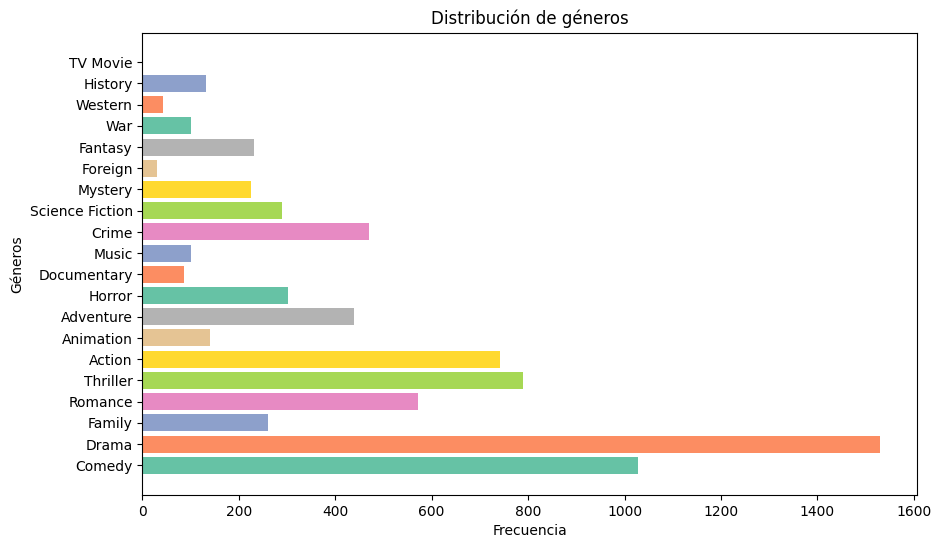

In [35]:
from collections import Counter

genre_counts = Counter([genre for genres in list_of_genres for genre in genres])

genres = list(genre_counts.keys())
frequencies = list(genre_counts.values())

fig, ax = plt.subplots(figsize=(10, 6))

palette = sns.color_palette("Set2", len(genres))

bars = ax.barh(genres, frequencies, color=palette)

plt.xlabel('Frecuencia')
plt.ylabel('Géneros')
plt.title('Distribución de géneros')

plt.show()

Creacción de nuevas variables binarias para los géneros

In [36]:
train_clean['num_genres'] = train_clean['genres'].apply(lambda x: len(x) if x != {} else 0)
train_clean['all_genres'] = train_clean['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]
for g in top_genres:
    train_clean['genre_' + g] = train_clean['all_genres'].apply(lambda x: 1 if g in x else 0)

test_clean['num_genres'] = test_clean['genres'].apply(lambda x: len(x) if x != {} else 0)
test_clean['all_genres'] = test_clean['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_genres = [m[0] for m in Counter([i for j in list_of_genres_2 for i in j]).most_common(15)]
for g in top_genres:
    test_clean['genre_' + g] = test_clean['all_genres'].apply(lambda x: 1 if g in x else 0)

In [ ]:
drama=train_clean.loc[train_clean['genre_Drama']==1,]
comedy=train_clean.loc[train_clean['genre_Comedy']==1,]
action=train_clean.loc[train_clean['genre_Action']==1,]
thriller=train_clean.loc[train_clean['genre_Thriller']==1,]

text_drama = " ".join(review for review in drama['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else ''))
text_comedy = " ".join(review for review in comedy['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else ''))
text_action = " ".join(review for review in action['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else ''))
text_thriller = " ".join(review for review in thriller['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else ''))

wordcloud1 = WordCloud(stopwords=stopwords, background_color="#EEEEEE", colormap="Reds", relative_scaling=0.5).generate(text_drama)
wordcloud2 = WordCloud(stopwords=stopwords, background_color="#EEEEEE", colormap="Blues", relative_scaling=0.5).generate(text_comedy)
wordcloud3 = WordCloud(stopwords=stopwords, background_color="#EEEEEE", colormap="Greens", relative_scaling=0.5).generate(text_action)
wordcloud4 = WordCloud(stopwords=stopwords, background_color="#EEEEEE", colormap="Greys", relative_scaling=0.5).generate(text_thriller)

fig = plt.figure(figsize=(25, 20))

plt.subplot(221)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.title('Drama Keywords')
plt.axis("off")

plt.subplot(222)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.title('Comedy Keywords')
plt.axis("off")
plt.show()

fig = plt.figure(figsize=(25, 20))

plt.subplot(223)
plt.imshow(wordcloud3, interpolation='bilinear')
plt.title('Action Keywords')
plt.axis("off")

plt.subplot(224)
plt.imshow(wordcloud4, interpolation='bilinear')
plt.title('Thriller Keywords')
plt.axis("off")
plt.show()

Eliminación de la variable genres

In [39]:
train_clean = train_clean.drop(['genres'], axis=1)
test_clean = test_clean.drop(['genres'], axis=1)

¿Cuántas production companies hay por película?

In [40]:
print('Número de production companies por película')
train_clean['production_companies'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Número de production companies por película


1     775
2     734
3     582
4     312
5     166
0     156
6     118
7      62
8      42
9      29
10      7
11      7
12      3
15      2
16      2
13      1
14      1
17      1
Name: production_companies, dtype: int64

<ipython-input-41-4e0d7877ae9d>:5: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



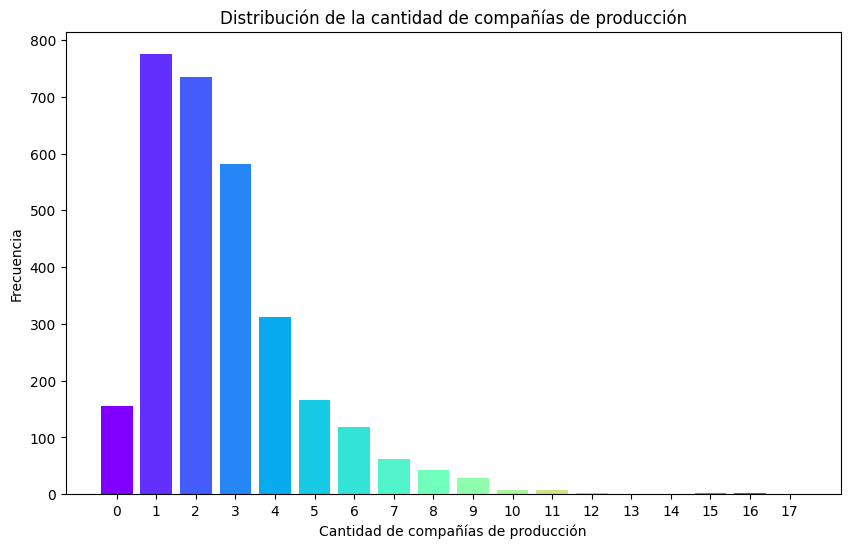

In [41]:
production_counts = Counter(train_clean['production_companies'].apply(lambda x: len(x) if x != {} else 0))

quantities, frequencies = zip(*sorted(production_counts.items()))

colors = plt.cm.get_cmap('rainbow', len(quantities))

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(range(len(quantities)), frequencies, color=colors(np.arange(len(quantities))))

ax.set_xticks(range(len(quantities)))
ax.set_xticklabels(quantities)

plt.xlabel('Cantidad de compañías de producción')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad de compañías de producción')

plt.show()

Lista de compañías de producción

In [42]:
list_of_companies = list(train_clean['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
list_of_companies_2 = list(test_clean['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

Creción de nuevas variables binarias para las compañías de producción

In [43]:
train_clean['num_companies'] = train_clean['production_companies'].apply(lambda x: len(x) if x != {} else 0)
train_clean['all_production_companies'] = train_clean['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)]
for g in top_companies:
    train_clean['production_company_' + g] = train_clean['all_production_companies'].apply(lambda x: 1 if g in x else 0)

test_clean['num_companies'] = test_clean['production_companies'].apply(lambda x: len(x) if x != {} else 0)
test_clean['all_production_companies'] = test_clean['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_companies = [m[0] for m in Counter([i for j in list_of_companies_2 for i in j]).most_common(30)]
for g in top_companies:
    test_clean['production_company_' + g] = test_clean['all_production_companies'].apply(lambda x: 1 if g in x else 0)

Eliminación de variables 'production_companies' y 'all_production_companies'

In [44]:
train_clean = train_clean.drop(['production_companies', 'all_production_companies'], axis=1)
test_clean = test_clean.drop(['production_companies', 'all_production_companies'], axis=1)

¿Cuántos países intervienen en la producción de cada película?

In [45]:
print('Número de production countries por película')
train_clean['production_countries'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Número de production countries por película


1    2222
2     525
3     116
4      57
0      55
5      21
6       3
8       1
Name: production_countries, dtype: int64

¿Cuáles son los países que más participan en la producción de películas?

In [46]:
list_of_countries = list(train_clean['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_countries for i in j]).most_common(25)
list_of_countries_2 = list(test_clean['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

Gráfico para ilustrar los países de producción

<ipython-input-47-ae79084354da>:11: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

<ipython-input-47-ae79084354da>:23: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



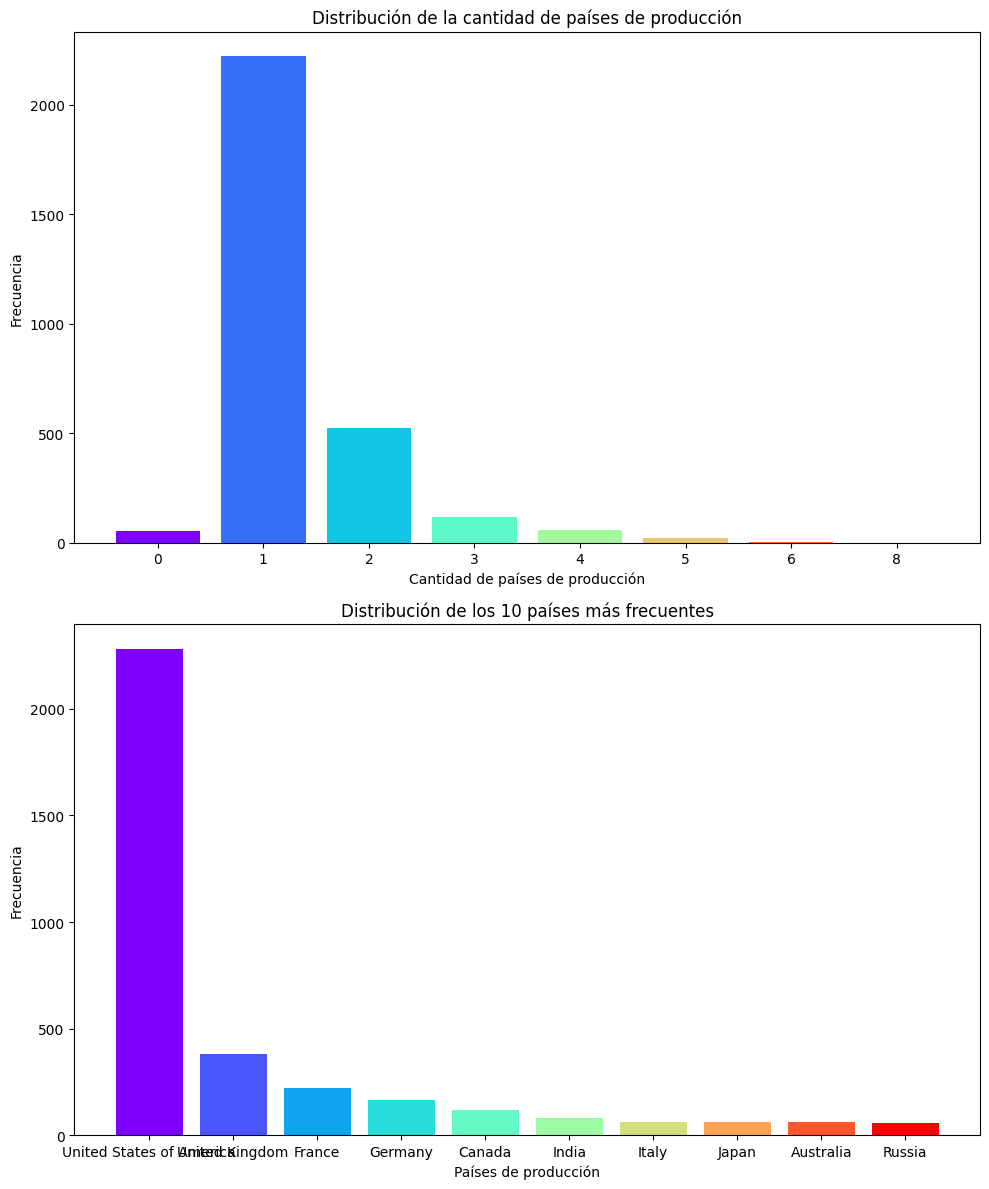

In [47]:
country_counts = Counter(train_clean['production_countries'].apply(lambda x: len(x) if x != {} else 0))

list_of_countries = list(train_clean['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

quantities = list(country_counts.keys())
frequencies = list(country_counts.values())
quantities_sorted = sorted(quantities)
frequencies_sorted = [frequencies[quantities.index(q)] for q in quantities_sorted]
colors = plt.cm.get_cmap('rainbow', len(quantities_sorted))
ax1.bar(range(len(quantities_sorted)), frequencies_sorted, color=colors(np.arange(len(quantities_sorted))))
ax1.set_xticks(range(len(quantities_sorted)))
ax1.set_xticklabels(quantities_sorted)
ax1.set_xlabel('Cantidad de países de producción')
ax1.set_ylabel('Frecuencia')
ax1.set_title('Distribución de la cantidad de países de producción')

country_counts = Counter([country for countries in list_of_countries for country in countries])
top_countries = country_counts.most_common(10)
quantities = [c[0] for c in top_countries]
frequencies = [c[1] for c in top_countries]
colors = plt.cm.get_cmap('rainbow', len(quantities))
ax2.bar(range(len(quantities)), frequencies, color=colors(np.arange(len(quantities))))
ax2.set_xticks(range(len(quantities)))
ax2.set_xticklabels(quantities)
ax2.set_xlabel('Países de producción')
ax2.set_ylabel('Frecuencia')
ax2.set_title('Distribución de los 10 países más frecuentes')

plt.tight_layout()

plt.show()

Creción de nuevas variables binarias para los países de producción

In [49]:
train_clean['num_countries'] = train_clean['production_countries'].apply(lambda x: len(x) if x != {} else 0)
train_clean['all_countries'] = train_clean['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(25)]
for g in top_countries:
    train_clean['production_country_' + g] = train_clean['all_countries'].apply(lambda x: 1 if g in x else 0)

test_clean['num_countries'] = test_clean['production_countries'].apply(lambda x: len(x) if x != {} else 0)
test_clean['all_countries'] = test_clean['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_countries = [m[0] for m in Counter([i for j in list_of_countries_2 for i in j]).most_common(25)]
for g in top_countries:
    test_clean['production_country_' + g] = test_clean['all_countries'].apply(lambda x: 1 if g in x else 0)

Eliminación de variables 'production_countries' y 'all_countries'

In [ ]:
train_clean = train_clean.drop(['production_countries', 'all_countries'], axis=1)
test_clean = test_clean.drop(['production_countries', 'all_countries'], axis=1)

¿Cuántos lenguajes se hablan por película?

In [51]:
print('Número de idiomas por película')
train_clean['spoken_languages'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Número de idiomas por película


1    2105
2     549
3     216
4      72
5      23
0      20
7       6
6       6
8       2
9       1
Name: spoken_languages, dtype: int64

¿Qué idiomas se hablan en cada película?

In [52]:
list_of_languages = list(train_clean['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
list_of_languages_2 = list(test_clean['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_languages for i in j]).most_common(15)

[('English', 2618),
 ('Français', 288),
 ('Español', 239),
 ('Deutsch', 169),
 ('Pусский', 152),
 ('Italiano', 124),
 ('日本語', 89),
 ('普通话', 68),
 ('हिन्दी', 56),
 ('', 47),
 ('Português', 43),
 ('العربية', 40),
 ('한국어/조선말', 37),
 ('广州话 / 廣州話', 36),
 ('தமிழ்', 27)]

<ipython-input-53-007c3d47d2a6>:11: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

<ipython-input-53-007c3d47d2a6>:23: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



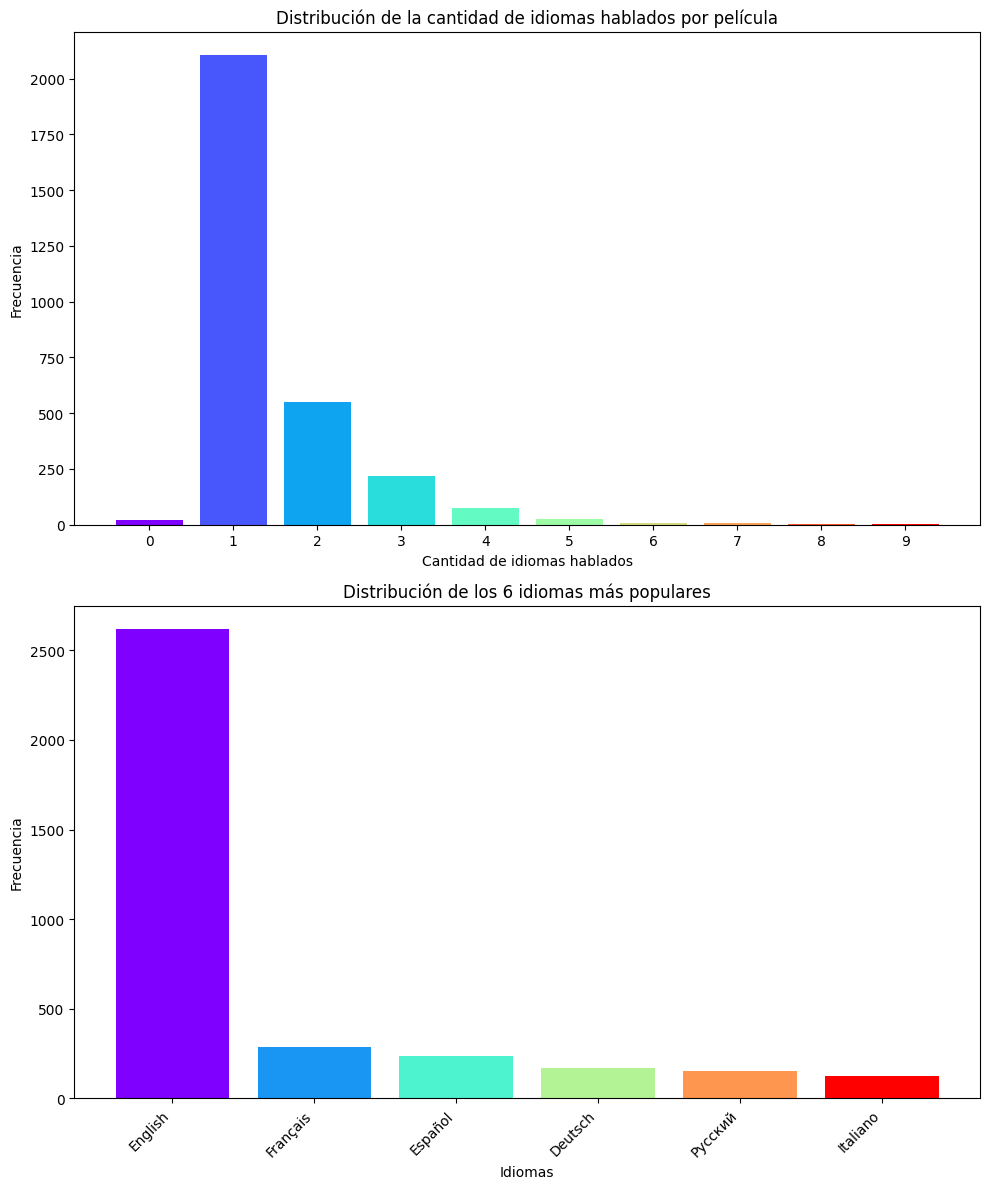

In [53]:
language_counts = Counter(train_clean['spoken_languages'].apply(lambda x: len(x) if x != {} else 0))

list_of_languages = list(train_clean['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

quantities = list(language_counts.keys())
frequencies = list(language_counts.values())
quantities_sorted = sorted(quantities)
frequencies_sorted = [frequencies[quantities.index(q)] for q in quantities_sorted]
colors = plt.cm.get_cmap('rainbow', len(quantities_sorted))
ax1.bar(range(len(quantities_sorted)), frequencies_sorted, color=colors(np.arange(len(quantities_sorted))))
ax1.set_xticks(range(len(quantities_sorted)))
ax1.set_xticklabels(quantities_sorted)
ax1.set_xlabel('Cantidad de idiomas hablados')
ax1.set_ylabel('Frecuencia')
ax1.set_title('Distribución de la cantidad de idiomas hablados por película')

language_counts = Counter([language for languages in list_of_languages for language in languages])
top_languages = language_counts.most_common(6)
languages = [l[0] for l in top_languages]
frequencies = [l[1] for l in top_languages]
colors = plt.cm.get_cmap('rainbow', len(languages))
ax2.bar(range(len(languages)), frequencies, color=colors(np.arange(len(languages))))
ax2.set_xticks(range(len(languages)))
ax2.set_xticklabels(languages, rotation=45, ha='right')
ax2.set_xlabel('Idiomas')
ax2.set_ylabel('Frecuencia')
ax2.set_title('Distribución de los 6 idiomas más populares')

plt.tight_layout()

plt.show()

Creción de nuevas variables binarias para los idiomas

In [ ]:
train_clean['num_languages'] = train_clean['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
train_clean['all_languages'] = train_clean['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_languages = [m[0] for m in Counter([i for j in list_of_languages for i in j]).most_common(30)]
for g in top_languages:
    train_clean['language_' + g] = train_clean['all_languages'].apply(lambda x: 1 if g in x else 0)

test_clean['num_languages'] = test_clean['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
test_clean['all_languages'] = test_clean['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_languages = [m[0] for m in Counter([i for j in list_of_languages_2 for i in j]).most_common(30)]
for g in top_languages:
    test_clean['language_' + g] = test_clean['all_languages'].apply(lambda x: 1 if g in x else 0)

Eliminación de variables 'spoken_languages' y 'all_languages'

In [55]:
train_clean = train_clean.drop(['spoken_languages', 'all_languages'], axis=1)
test_clean = test_clean.drop(['spoken_languages', 'all_languages'], axis=1)

¿Cuántas Keyword hay por película?

In [56]:
print('Número de Keywords por película')
train_clean['Keywords'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Número de Keywords por película


5    293
0    276
4    248
3    228
6    227
2    207
7    192
1    187
8    161
9    134
Name: Keywords, dtype: int64

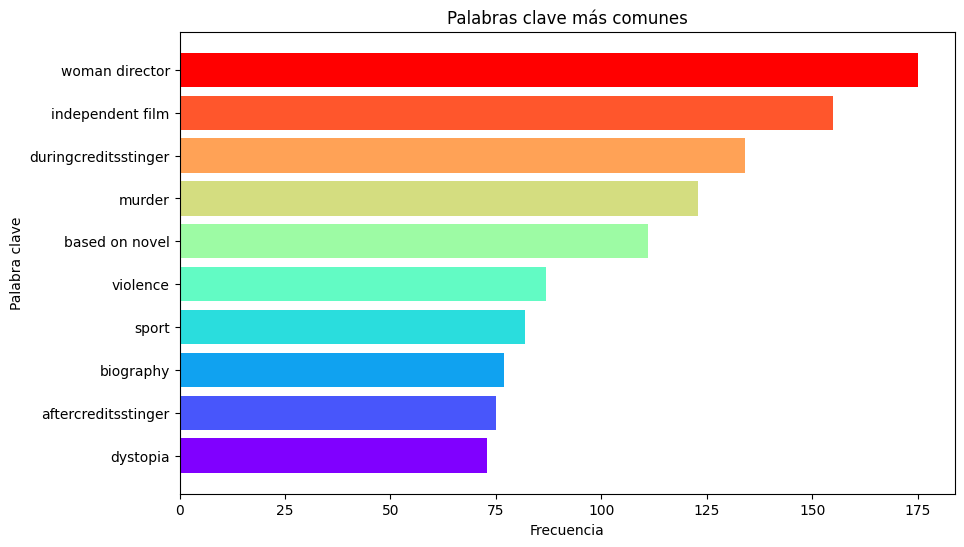

In [57]:
list_of_keywords = list(train_clean['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
list_of_keywords_2 = list(test_clean['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

keyword_counter = Counter([keyword for sublist in list_of_keywords for keyword in sublist])

top_keywords = keyword_counter.most_common(10)

keywords, counts = zip(*top_keywords)

keywords = list(keywords)[::-1]
counts = list(counts)[::-1]

num_bars = len(keywords)
colors = plt.cm.rainbow(np.linspace(0, 1, num_bars))

plt.figure(figsize=(10, 6))
plt.barh(keywords, counts, color=colors)

plt.title('Palabras clave más comunes')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra clave')

plt.show()

Creación de variables binarias para el N° de Keywords

In [ ]:
train_clean['num_Keywords'] = train_clean['Keywords'].apply(lambda x: len(x) if x != {} else 0)
train_clean['all_Keywords'] = train_clean['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_keywords = [m[0] for m in Counter([i for j in list_of_keywords for i in j]).most_common(30)]
for g in top_keywords:
    train_clean['keyword_' + g] = train_clean['all_Keywords'].apply(lambda x: 1 if g in x else 0)

test_clean['num_Keywords'] = test_clean['Keywords'].apply(lambda x: len(x) if x != {} else 0)
test_clean['all_Keywords'] = test_clean['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_keywords = [m[0] for m in Counter([i for j in list_of_keywords_2 for i in j]).most_common(30)]
for g in top_keywords:
    test_clean['keyword_' + g] = test_clean['all_Keywords'].apply(lambda x: 1 if g in x else 0)

Eliminación de las variables 'Keywords' y 'all_Keywords'

In [59]:
train_clean = train_clean.drop(['Keywords', 'all_Keywords'], axis=1)
test_clean = test_clean.drop(['Keywords', 'all_Keywords'], axis=1)

¿Cuántas personas hay en el elenco de cada película?

In [60]:
print('Número de casted persons por película')
train_clean['cast'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Número de casted persons por película


15    212
16    165
10    135
13    129
12    124
11    122
17    118
9     118
18    115
14    110
Name: cast, dtype: int64

In [61]:
list_of_cast_names = list(train_clean['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_names for i in j]).most_common(15)
list_of_cast_names_2 = list(test_clean['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_names_2 for i in j]).most_common(15)

[('Samuel L. Jackson', 50),
 ('Robert De Niro', 41),
 ('Steve Buscemi', 37),
 ('Bruce Willis', 37),
 ('Morgan Freeman', 34),
 ('Robin Williams', 34),
 ('Sylvester Stallone', 33),
 ('Johnny Depp', 32),
 ('Willem Dafoe', 32),
 ('Julianne Moore', 32),
 ('Nicolas Cage', 32),
 ('Liam Neeson', 32),
 ('Christopher Walken', 31),
 ('Ben Stiller', 31),
 ('Matt Damon', 31)]

<ipython-input-62-a0896c549621>:10: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



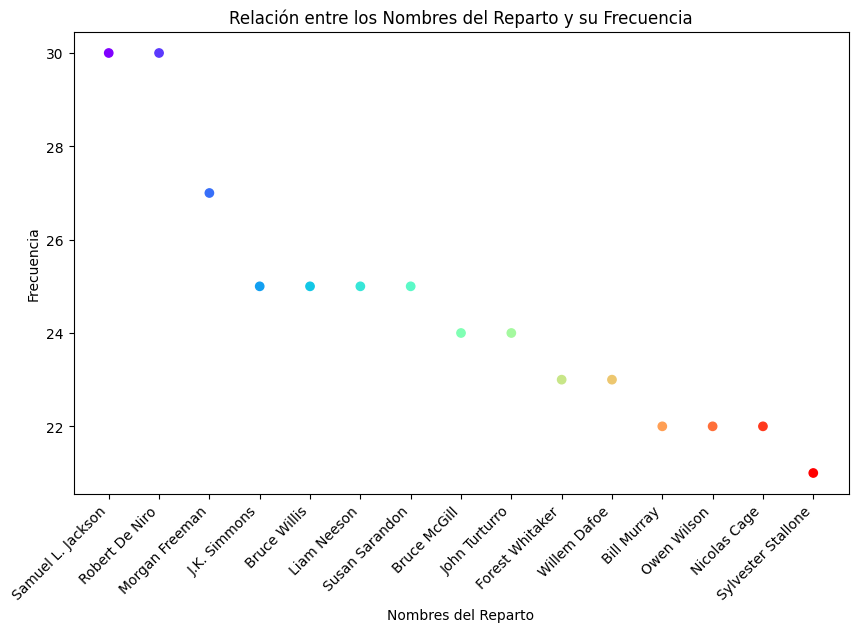

In [62]:
list_of_cast_names = list(train_clean['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

cast_counts = Counter([i for j in list_of_cast_names for i in j])
top_cast_names = cast_counts.most_common(15)

cast_names = [c[0] for c in top_cast_names]
frequencies = [c[1] for c in top_cast_names]

plt.figure(figsize=(10, 6))
cmap = plt.cm.get_cmap('rainbow', len(cast_names))
scatter = plt.scatter(cast_names, frequencies, c=range(len(cast_names)), cmap=cmap)
plt.xlabel('Nombres del Reparto')
plt.ylabel('Frecuencia')
plt.title('Relación entre los Nombres del Reparto y su Frecuencia')

plt.xticks(rotation=45, ha='right')

plt.show()

¿De qué genero son los miembros del elenco de cada película?

In [63]:
list_of_cast_genders = list(train_clean['cast'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_genders for i in j]).most_common()
list_of_cast_genders_2 = list(test_clean['cast'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_genders_2 for i in j]).most_common()

[(2, 41074), (0, 31691), (1, 20458)]

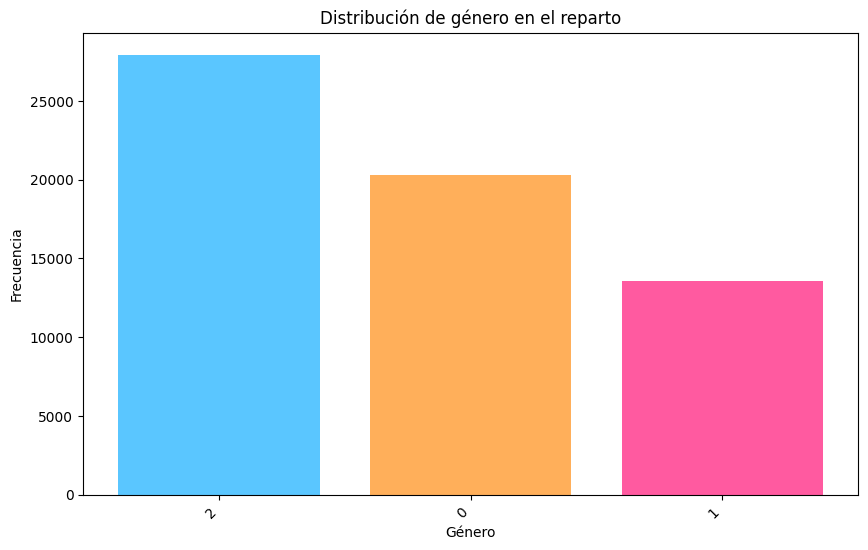

In [64]:
gender_counts = Counter([i for j in list_of_cast_genders for i in j]).most_common()

genders, counts = zip(*gender_counts)

colors = ["#5AC6FF", "#FFAF5A", "#FF5AA0"]

plt.figure(figsize=(10, 6))
plt.bar(range(len(genders)), counts, color=colors)

plt.xticks(range(len(genders)), genders, rotation=45, ha='right')

plt.title('Distribución de género en el reparto')
plt.xlabel('Género')
plt.ylabel('Frecuencia')

plt.show()

¿A qué personaje interpretan los miembros del cast?

In [65]:
list_of_cast_characters = list(train_clean['cast'].apply(lambda x: [i['character'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_characters for i in j]).most_common(15)
list_of_cast_characters_2 = list(test_clean['cast'].apply(lambda x: [i['character'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_characters_2 for i in j]).most_common(15)

[('', 1010),
 ('Himself', 887),
 ('Dancer', 241),
 ('Additional Voices (voice)', 235),
 ('Herself', 233),
 ('Reporter', 131),
 ('Doctor', 125),
 ('Nurse', 106),
 ('Soldier', 94),
 ('Bartender', 87),
 ('Additional Voice (voice)', 87),
 ('Extra: Bar / Comedy Club', 85),
 ('(uncredited)', 81),
 ('(voice)', 77),
 ('Waitress', 75)]

Creación de variables binarias para los miembros del reparto

In [ ]:
train_clean['num_cast'] = train_clean['cast'].apply(lambda x: len(x) if x != {} else 0)
top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(15)]
for g in top_cast_names:
    train_clean['cast_name_' + g] = train_clean['cast'].apply(lambda x: 1 if g in str(x) else 0)
train_clean['genders_0_cast'] = train_clean['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train_clean['genders_1_cast'] = train_clean['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train_clean['genders_2_cast'] = train_clean['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_cast_characters = [m[0] for m in Counter([i for j in list_of_cast_characters for i in j]).most_common(15)]
for g in top_cast_characters:
    train_clean['cast_character_' + g] = train_clean['cast'].apply(lambda x: 1 if g in str(x) else 0)

test_clean['num_cast'] = test_clean['cast'].apply(lambda x: len(x) if x != {} else 0)
top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names_2 for i in j]).most_common(15)]
for g in top_cast_names:
    test_clean['cast_name_' + g] = train_clean['cast'].apply(lambda x: 1 if g in str(x) else 0)
test_clean['genders_0_cast'] = test_clean['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test_clean['genders_1_cast'] = test_clean['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test_clean['genders_2_cast'] = test_clean['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_cast_characters = [m[0] for m in Counter([i for j in list_of_cast_characters_2 for i in j]).most_common(15)]
for g in top_cast_characters:
    test_clean['cast_character_' + g] = test_clean['cast'].apply(lambda x: 1 if g in str(x) else 0)

Eliminación de variable 'cast'

In [67]:
train_clean = train_clean.drop(['cast'], axis=1)
test_clean = test_clean.drop(['cast'], axis=1)

¿Cuales son los miembros de crew mas prensentes en las películas?

In [68]:
list_of_crew_names = list(train_clean['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_names for i in j]).most_common(15)
list_of_crew_names_2 = list(test_clean['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_names_2 for i in j]).most_common(15)

[('Steven Spielberg', 67),
 ('Mary Vernieu', 61),
 ('Bob Weinstein', 57),
 ('Robert Rodriguez', 56),
 ('Harvey Weinstein', 56),
 ('Hans Zimmer', 55),
 ('Avy Kaufman', 55),
 ('John Williams', 50),
 ('Deborah Aquila', 48),
 ('Tricia Wood', 48),
 ('James Horner', 46),
 ('Kerry Barden', 42),
 ('James Newton Howard', 42),
 ('Alan Silvestri', 41),
 ('Francine Maisler', 40)]

¿Cuáles son los trabajos más usuales entre los miembros del crew?

In [69]:
list_of_crew_jobs = list(train_clean['crew'].apply(lambda x: [i['job'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)
list_of_crew_jobs_2 = list(test_clean['crew'].apply(lambda x: [i['job'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)

[('Producer', 6011),
 ('Executive Producer', 3459),
 ('Director', 3225),
 ('Screenplay', 2996),
 ('Editor', 2824),
 ('Casting', 2483),
 ('Director of Photography', 2288),
 ('Original Music Composer', 1947),
 ('Art Direction', 1821),
 ('Production Design', 1650),
 ('Costume Design', 1573),
 ('Writer', 1523),
 ('Set Decoration', 1345),
 ('Makeup Artist', 1108),
 ('Sound Re-Recording Mixer', 970)]

¿De qué género son?

In [70]:
list_of_crew_genders = list(train_clean['crew'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_genders for i in j]).most_common(15)
list_of_crew_genders_2 = list(test_clean['crew'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_genders_2 for i in j]).most_common(15)

[(0, 61652), (2, 35833), (1, 9008)]

¿A qué departamento pertenecen?

In [71]:
list_of_crew_departments = list(train_clean['crew'].apply(lambda x: [i['department'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_departments for i in j]).most_common(14)
list_of_crew_departments_2 = list(test_clean['crew'].apply(lambda x: [i['department'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_departments_2 for i in j]).most_common(14)

[('Production', 23040),
 ('Sound', 13178),
 ('Art', 11801),
 ('Crew', 10214),
 ('Writing', 9762),
 ('Costume & Make-Up', 9067),
 ('Camera', 7805),
 ('Directing', 7291),
 ('Editing', 6627),
 ('Visual Effects', 5881),
 ('Lighting', 1826),
 ('Actors', 1)]

Creación de variables binarias para los miembros del crew

In [ ]:
train_clean['num_crew'] = train_clean['crew'].apply(lambda x: len(x) if x != {} else 0)
top_crew_names = [m[0] for m in Counter([i for j in list_of_crew_names for i in j]).most_common(15)]
for g in top_crew_names:
    train_clean['crew_name_' + g] = train_clean['crew'].apply(lambda x: 1 if g in str(x) else 0)
train_clean['genders_0_crew'] = train_clean['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train_clean['genders_1_crew'] = train_clean['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train_clean['genders_2_crew'] = train_clean['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_crew_jobs = [m[0] for m in Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)]
for j in top_crew_jobs:
    train_clean['jobs_' + j] = train_clean['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
top_crew_departments = [m[0] for m in Counter([i for j in list_of_crew_departments for i in j]).most_common(15)]
for j in top_crew_departments:
    train_clean['departments_' + j] = train_clean['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j]))

test_clean['num_crew'] = test_clean['crew'].apply(lambda x: len(x) if x != {} else 0)
top_crew_names_2 = [m[0] for m in Counter([i for j in list_of_crew_names_2 for i in j]).most_common(15)]
for g in top_crew_names_2:
    test_clean['crew_name_' + g] = test_clean['crew'].apply(lambda x: 1 if g in str(x) else 0)
test_clean['genders_0_crew'] = test_clean['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test_clean['genders_1_crew'] = test_clean['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test_clean['genders_2_crew'] = test_clean['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_crew_jobs_2 = [m[0] for m in Counter([i for j in list_of_crew_jobs_2 for i in j]).most_common(15)]
for j in top_crew_jobs_2:
    test_clean['jobs_' + j] = test_clean['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
top_crew_departments_2 = [m[0] for m in Counter([i for j in list_of_crew_departments_2 for i in j]).most_common(15)]
for j in top_crew_departments_2:
    test_clean['departments_' + j] = test_clean['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j]))

Eliminación de la variable 'crew'

In [73]:
train_clean = train_clean.drop(['crew'], axis=1)
test_clean = test_clean.drop(['crew'], axis=1)

# Otras correciones

In [74]:
mean_runtime = train_clean['runtime'].mean()
train_clean['runtime'].fillna(mean_runtime, inplace=True)

Limpieza de fecha

In [75]:
def fix_date(x):
    year = x.split('/')[2]
    if int(year) <= 19:
        return x[:-2] + '20' + year
    else:
        return x[:-2] + '19' + year

In [76]:
train_clean.loc[train_clean['release_date'].isnull() == True, 'release_date'] = '01/01/98'
test_clean.loc[test_clean['release_date'].isnull() == True, 'release_date'] = '01/01/98'

In [77]:
train_clean['release_date'] = train_clean['release_date'].apply(lambda x: fix_date(x))
test_clean['release_date'] = test_clean['release_date'].apply(lambda x: fix_date(x))
train_clean['release_date'] = pd.to_datetime(train_clean['release_date'])
test_clean['release_date'] = pd.to_datetime(test_clean['release_date'])

In [ ]:
def process_date(df):
    date_parts = ["year", "weekday", "month", 'weekofyear', 'day', 'quarter']
    for part in date_parts:
        part_col = 'release_date' + "_" + part
        df[part_col] = getattr(df['release_date'].dt, part).astype(int)

    return df

train_clean = process_date(train_clean)
test_clean = process_date(test_clean)

¿Como afecta el día de estreno al revenue?

<ipython-input-79-8a4acb7571b8>:3: FutureWarning:

Passing `palette` without assigning `hue` is deprecated.



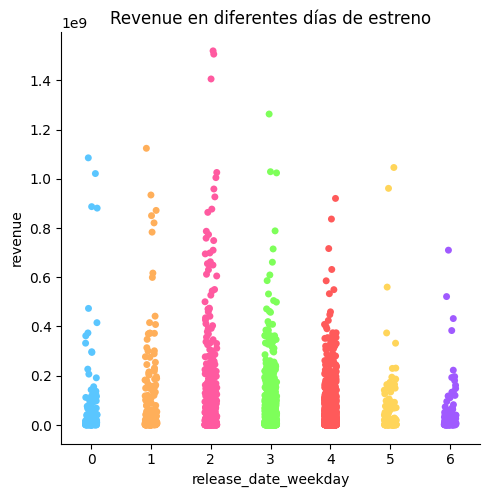

In [79]:
day_palette = ["#5AC6FF", "#FFAF5A", "#FF5AA0", "#7EFF5A", "#FF5A5A", "#FFD55A", "#A05AFF"]

sns.catplot(x='release_date_weekday', y='revenue', data=train_clean, palette=day_palette)
plt.title('Revenue en diferentes días de estreno')

plt.show()

Eliminación de otras variables

In [80]:
train_clean = train_clean.drop(['homepage', 'imdb_id', 'poster_path', 'release_date', 'status', 'log_revenue'], axis=1)
test_clean = test_clean.drop(['homepage', 'imdb_id', 'poster_path', 'release_date', 'status'], axis=1)

¿Qué columnas están compuestas de valores repetidos? Eliminar estas variables

In [82]:
for col in train_clean.columns:
    if train_clean[col].nunique() == 1:
        print(col)
        train_clean = train_clean.drop([col], axis=1)

language_
cast_character_


In [79]:
for col in test_clean.columns:
    if test_clean[col].nunique() == 1:
        print(col)
        test_clean = test_clean.drop([col], axis=1)

language_
cast_character_


¿Que tipos de dato tienen las bases a esta altura?

In [83]:
column_types = train_clean.dtypes
unique_types = column_types.unique()

print("Tipos de datos únicos de las columnas de train:")
print(unique_types)

Tipos de datos únicos de las columnas de train:
[dtype('int64') dtype('O') dtype('float64')]


In [81]:
column_types_2 = test_clean.dtypes
unique_types_2 = column_types.unique()

print("Tipos de datos únicos de las columnas de test:")
print(unique_types)

Tipos de datos únicos de las columnas de test:
[dtype('int64') dtype('O') dtype('float64')]


¿Cuales son las columnas no numéricas (O)?

In [84]:
object_columns = train_clean.select_dtypes(include=['object'])
print("Columnas tipo object de train: ",object_columns.columns)

Columnas tipo object de train:  Index(['original_language', 'original_title', 'overview', 'tagline', 'title',
       'collection_name', 'all_genres'],
      dtype='object')


In [83]:
object_columns_2 = test_clean.select_dtypes(include=['object'])
print("Columnas tipo object de test: ",object_columns.columns)

Columnas tipo object de test:  Index(['original_language', 'original_title', 'overview', 'tagline', 'title',
       'collection_name', 'all_genres'],
      dtype='object')


In [ ]:
train_clean.isna().sum()

# Transformación con Label Encoder

In [86]:
for col in ['original_language', 'collection_name', 'all_genres']:
    le = LabelEncoder()
    le.fit(list(train_clean[col].fillna('')) + list(test_clean[col].fillna('')))
    train_clean[col] = le.transform(train_clean[col].fillna('').astype(str))
    test_clean[col] = le.transform(test_clean[col].fillna('').astype(str))

Selección de columnas con texto

In [88]:
train_texts = train_clean[['title', 'tagline', 'overview', 'original_title']]
test_texts = test_clean[['title', 'tagline', 'overview', 'original_title']]

Creación de nuevas variables para el largo y cantidad de palabras de las columnas de texto + Eliminación de columnas originales

In [89]:
for col in ['title', 'tagline', 'overview', 'original_title']:
    train_clean['len_' + col] = train_clean[col].fillna('').apply(lambda x: len(str(x)))
    train_clean['words_' + col] = train_clean[col].fillna('').apply(lambda x: len(str(x.split(' '))))
    train_clean = train_clean.drop(col, axis=1)
    test_clean['len_' + col] = test_clean[col].fillna('').apply(lambda x: len(str(x)))
    test_clean['words_' + col] = test_clean[col].fillna('').apply(lambda x: len(str(x.split(' '))))
    test_clean = test_clean.drop(col, axis=1)

Separación de la base

In [90]:
X = train_clean.drop(['id', 'revenue'], axis=1)
y = np.log1p(train_clean['revenue'])
X_test = test_clean.drop(['id'], axis=1)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo 1, LGBM (R2: 0.55 y RMSE: 2.00)

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import r2_score

params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 6,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}

model_lgbm1 = lgb.LGBMRegressor(**params, n_estimators=20000, nthread=4, n_jobs=-1)
model_lgbm1.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='rmse',
                verbose=1000, early_stopping_rounds=200)

y_pred = model_lgbm1.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R2 del modelo LGBM:", r2)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE del modelo LGBM:", rmse)

feature_importance = model_lgbm1.feature_importances_

importance_df = pd.DataFrame({'Característica': X_train.columns, 'Importancia': feature_importance})
importance_df = importance_df.sort_values(by='Importancia', ascending=False)

print("Importancia de características:")
print(importance_df)

Como era esperable, las variables binarias son las últimas en cuando a importancia

LGBM con Random Search

In [ ]:
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV

params = {'num_leaves': [20, 30, 40],
          'min_data_in_leaf': [10, 20, 30],
          'max_depth': [4, 5, 6],
          'learning_rate': [0.01, 0.05, 0.1],
          'lambda_l1': [0.1, 0.2, 0.3]}

model = lgb.LGBMRegressor(objective='regression', boosting='gbdt', feature_fraction=0.9,
                          bagging_freq=1, bagging_fraction=0.9, bagging_seed=11,
                          metric='rmse', verbosity=-1, n_estimators=20000,
                          nthread=4, n_jobs=-1)

random_search = RandomizedSearchCV(estimator=model, param_distributions=params, cv=5, scoring='r2', n_iter=10)
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R2 del modelo LGBM:", r2)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE del modelo LGBM:", rmse)

best_params = random_search.best_params_
print("Mejores hiperparámetros:", best_params)

#R2 del modelo LGBM: 0.5353003151295845
#RMSE del modelo LGBM: 2.035090664131001
#Mejores hiperparámetros: {'num_leaves': 20, 'min_data_in_leaf': 10, 'max_depth': 6, 'learning_rate': 0.01, 'lambda_l1': 0.1}

LGBM filtrando caracterísitcas (R2: 0.5490 Y RMSE: 2.0048)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import lightgbm as lgb

params = {
    'num_leaves': 30,
    'min_data_in_leaf': 20,
    'objective': 'regression',
    'max_depth': 5,
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.2,
    "verbosity": -1
}

feature_importance = model_lgbm1.feature_importances_

feature_importance_list = list(zip(X_train.columns, feature_importance))

sorted_features = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)

threshold = 0.1 * sorted_features[0][1]

features_to_remove = [feat[0] for feat in sorted_features if feat[1] < threshold]

print("Características eliminadas:")
for feature in features_to_remove:
    print(feature)

X_train_filtered = X_train.drop(features_to_remove, axis=1)
X_test_filtered = X_test.drop(features_to_remove, axis=1)

model_lgbm_filtered = lgb.LGBMRegressor(**params, n_estimators=20000, nthread=4, n_jobs=-1)
model_lgbm_filtered.fit(X_train_filtered, y_train,
                         eval_set=[(X_train_filtered, y_train), (X_test_filtered, y_test)],
                         eval_metric='rmse', verbose=1000, early_stopping_rounds=200)

y_pred_filtered = model_lgbm_filtered.predict(X_test_filtered)

r2_filtered = r2_score(y_test, y_pred_filtered)
print("R2 del modelo LGBM con características filtradas:", r2_filtered)
rmse_filtered = mean_squared_error(y_test, y_pred_filtered, squared=False)
print("RMSE del modelo LGBM con características filtradas:", rmse_filtered)


In [94]:
pip install eli5

In [95]:
import eli5

In [ ]:
from IPython.display import display, HTML

params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 6,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}

model = lgb.LGBMRegressor(**params, n_estimators=20000, nthread=4, n_jobs=-1)
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='rmse',
          verbose=1000, early_stopping_rounds=200)

weights_table = eli5.show_weights(model, feature_filter=lambda x: x != '<BIAS>')
html = weights_table.data

html = html.replace('<table', '<table style="color: black"')

display(HTML(html))


# Modelo 2, XGB (R2 = 0,53 y RMSE: 2.0319)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

model_XGB = xgb.train(params, dtrain, num_boost_round=100)

y_pred = model_XGB.predict(dtest)

r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE del modelo XGB:", rmse)

R2 Score: 0.5226841765111266
RMSE del modelo XGB: 2.0319503299818718


XGB con GridSearch (tarda +7hs, no se llegó a un resultado)

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'n_estimators': [100, 200]
}

model = xgb.XGBRegressor(objective='reg:squarederror', seed=42)

grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)

# Modelo 3, Regresión Lineal (R2 = 0,4 y RMSE: 2,26)

In [91]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

model_rl = LinearRegression()

param_grid = {
    'fit_intercept': [True, False]
}

random_search = RandomizedSearchCV(estimator=model_rl, param_distributions=param_grid, scoring='r2', n_iter=10, cv=5)
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE del modelo de Regresión Lineal:", rmse)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning:

The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.



R2 Score: 0.40930945962046106
RMSE del modelo de Regresión Lineal: 2.260425404620161


# CatBoost (R2 = 0,57 y RMSE: 1,9622)

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score

model_cb1 = CatBoostRegressor(iterations=100000,
                                 learning_rate=0.004,
                                 depth=5,
                                 eval_metric='RMSE',
                                 colsample_bylevel=0.8,
                                 bagging_temperature = 0.2,
                                 metric_period = None,
                                 early_stopping_rounds=200
                                )

model_cb1.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

y_pred = model_cb1.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE del modelo CatBoost:", rmse)

y_pred = model.predict(X_test)

print(y_pred)

CatBoost utilizado K-Folds

In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error

params = {
    'iterations': 100000,
    'learning_rate': 0.004,
    'depth': 5,
    'eval_metric': 'RMSE',
    'colsample_bylevel': 0.8,
    'bagging_temperature': 0.2,
    'metric_period': None,
    'early_stopping_rounds': 200
}

r2_scores = []
rmse_scores = []

n_splits = 5

kf = KFold(n_splits=n_splits, random_state=42, shuffle=True)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model_cb1 = CatBoostRegressor(**params)
    model_cb1.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

    y_pred = model_cb1.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    r2_scores.append(r2)
    rmse_scores.append(rmse)

mean_r2 = sum(r2_scores) / len(r2_scores)
mean_rmse = sum(rmse_scores) / len(rmse_scores)

print("Mean R2 Score:", mean_r2)
print("Mean RMSE Score:", mean_rmse)

CatBoost con RandomSearch (tarda mucho)

In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
import numpy as np

model = CatBoostRegressor(iterations=100000,
                          learning_rate=0.004,
                          depth=5,
                          eval_metric='RMSE',
                          colsample_bylevel=0.8,
                          bagging_temperature=0.2,
                          metric_period=None,
                          early_stopping_rounds=200)

param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'depth': [3, 5, 7],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [0.2, 0.5, 0.8]
}

random_search = RandomizedSearchCV(model, param_grid, cv=5, scoring='r2', n_iter=10, random_state=42)
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
best_params = random_search.best_params_

best_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R2 Score del modelo CatBoost:", r2)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE del modelo CatBoost:", rmse)

print("Best Parameters:", best_params)

# Nuevas variables e importancia

In [100]:
def new_features(df):
    df['budget_to_popularity'] = df['budget'] / df['popularity']
    df['budget_to_runtime'] = df['budget'] / df['runtime']

    df['_budget_year_ratio'] = df['budget'] / (df['release_date_year'] * df['release_date_year'])
    df['_releaseYear_popularity_ratio'] = df['release_date_year'] / df['popularity']
    df['_releaseYear_popularity_ratio2'] = df['popularity'] / df['release_date_year']

    df['runtime_to_mean_year'] = df['runtime'] / df.groupby("release_date_year")["runtime"].transform('mean')
    df['popularity_to_mean_year'] = df['popularity'] / df.groupby("release_date_year")["popularity"].transform('mean')
    df['budget_to_mean_year'] = df['budget'] / df.groupby("release_date_year")["budget"].transform('mean')

    return df

In [101]:
train_clean = new_features(train_clean)
test_clean = new_features(test_clean)

In [102]:
X = train_clean.drop(['id', 'revenue'], axis=1)
y = np.log1p(train_clean['revenue'])
X_test = test_clean.drop(['id'], axis=1)

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

LGBM

Podemos ver que las nuevas variables tienen una importancia considerable

In [ ]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 6,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}

model = lgb.LGBMRegressor(**params, n_estimators=20000, nthread=4, n_jobs=-1)
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='rmse',
          verbose=1000, early_stopping_rounds=200)

weights_table = eli5.show_weights(model, feature_filter=lambda x: x != '<BIAS>')
html = weights_table.data

html = html.replace('<table', '<table style="color: black"')

display(HTML(html))